In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score


from chebai.result.utils import (
    evaluate_model,
    evaluate_model_regression,
    load_results_from_buffer,
)
from chebai.result.classification import print_metrics
from chebai.result.regression import print_metrics
from chebai.models.electra import Electra
from chebai.preprocessing.datasets.solCuration import SolCuration, SolCurationChem
from chebai.preprocessing.datasets.tox21 import Tox21MolNet
import os
import tqdm
import torch
import pickle

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

/Users/ctumes/Cheb-AI/chebai_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


## With Ontology finetuning

In [18]:
# specify the checkpoint name
checkpoint_name = "solFinetuningAGAIN_MSE2/version_0/checkpoints/per_epoch=99_val_loss=0.5071_val_mse=11.0217"
checkpoint_path = os.path.join("logs", f"{checkpoint_name}.ckpt")
kind = "test"  # replace with "train" / "validation" to run on train / validation sets
buffer_dir = os.path.join("results_buffer", checkpoint_name, kind)
# make sure to use the same data module and model class that were used during training
data_module = SolCurationChem()
# load chebi data if missing and perform dynamic splits
data_module.prepare_data()
data_module.setup()

model_class = Electra

[False, False, False]


In [19]:
# evaluates model, stores results in buffer_dir
# print(buffer_dir)
model = model_class.load_from_checkpoint(checkpoint_path)
model.model_type = 'regression'

preds_list, labels_list = evaluate_model_regression(
        model,
        data_module,
        buffer_dir='/Users/ctumes/Cheb-AI/chebai_helper/',
        # No need to provide this parameter for Chebi dataset, "kind" parameter should be provided
        filename='/Users/ctumes/python-chebai/data/SolCuration/processed/smiles_token/test.pt',
        batch_size=32,
        kind=kind,
)
# load data from buffer_dir
# preds, labels = load_results_from_buffer(buffer_dir, device=DEVICE)


00%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:45<00:00,  1.10s/it]

In [4]:
print(model.model_type)

regression


In [5]:
print(preds_list)
print(labels_list)
print(len(preds_list))
print(len(labels_list))

tensor([[-2.1897],
        [-3.9141],
        [-5.6935],
        ...,
        [-0.0093],
        [-5.4903],
        [-5.1491]], device='mps:0', grad_fn=<CatBackward0>)
tensor([[-1.9250],
        [-6.4172],
        [-4.8800],
        ...,
        [-0.1700],
        [-4.8041],
        [-4.9500]], device='mps:0')
1300
1300


In [20]:
# output relevant metrics
print_metrics(
    preds_list,
    labels_list,
    DEVICE,
    markdown_output=False,
)

MSE: 0.5399385690689087


In [7]:
print(preds_list.cpu().detach().numpy())

[[-2.1897364]
 [-3.9141192]
 [-5.693497 ]
 ...
 [-0.0092898]
 [-5.4903164]
 [-5.1490617]]


## Without Ontology Finetuning

In [15]:
# specify the checkpoint name
checkpoint_name = "solFinetuningAGAIN_MSE_NO_ONTO/version_0/checkpoints/per_epoch=74_val_loss=0.6037_val_mse=11.0069"
checkpoint_path = os.path.join("logs", f"{checkpoint_name}.ckpt")
kind = "test"  # replace with "train" / "validation" to run on train / validation sets
buffer_dir = os.path.join("results_buffer", checkpoint_name, kind)
# make sure to use the same data module and model class that were used during training
data_module2 = SolCurationChem()
# load chebi data if missing and perform dynamic splits
data_module2.prepare_data()
data_module2.setup()

model_class2 = Electra

# evaluates model, stores results in buffer_dir
# print(buffer_dir)
model2 = model_class2.load_from_checkpoint(checkpoint_path)
model2.model_type = 'regression'

preds_list2, labels_list2 = evaluate_model_regression(
        model2,
        data_module2,
        buffer_dir='/Users/ctumes/Cheb-AI/chebai_helper/',
        # No need to provide this parameter for Chebi dataset, "kind" parameter should be provided
        filename='/Users/ctumes/python-chebai/data/SolCuration/processed/smiles_token/test.pt',
        batch_size=32,
        kind=kind,
)

# output relevant metrics
print_metrics(
    preds_list2,
    labels_list2,
    DEVICE,
    markdown_output=False,
)

[False, False, False]


Some weights of ElectraModel were not initialized from the model checkpoint at None and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'embeddings_project.bias', 'embeddings_project.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encode


00%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:51<00:00,  1.26s/it]

MSE: 0.5454557538032532


## Plot everything

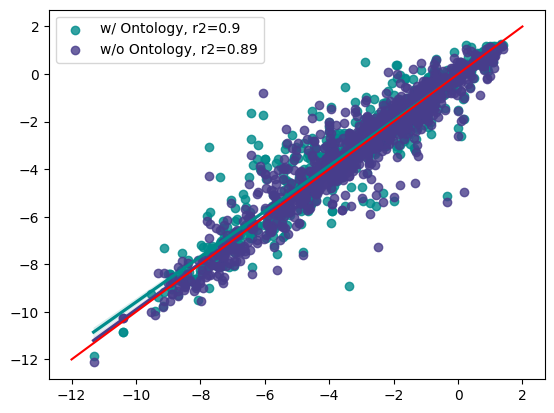

In [22]:
labels = labels_list.cpu().detach().numpy()
preds = preds_list.cpu().detach().numpy()

labels2 = labels_list2.cpu().detach().numpy()
preds2 = preds_list2.cpu().detach().numpy()

r2_with = r2_score(labels, preds)
r2_without = r2_score(labels2, preds2)

ax1 = sns.regplot(x=labels, y=preds, label=f'w/ Ontology, r2={r2_with:.2}', color='darkcyan')
ax2 = sns.regplot(x=labels2, y=preds2, label=f'w/o Ontology, r2={r2_without:.2}', color='darkslateblue')
bla = [-12,-11,-10,-9,-8,-7, -6, -5, -4, -3, -2, -1, 0, 1,2]
ax1.legend(loc="best")
plt.plot(bla, bla, color='red')
plt.savefig('../scatter_regression_december2.png')

# compare the exact values for each smiles between w/ and w/o Ontology
# also check how fast the model converges

for after the holiday: we use the eval fct in utils.py, predict_from_file in CustomTrainer.py seems to output different stuff which is why we get *very* different results for running it with the predict_from_file fct on the command line and the evaluate_model_regression fct here. Also, something seems to be wrong with the pre-trained model for when we do not use the ontology training step....hmmm

In [ ]:
# try as classification instead
# redo tox stuff
# do training plots for convergence
# moleculeNet

# ask martin:
## check logging MSE
## predict_from_file vs eval_model
## where does each of this yml files comes into place
## make a diagram or diagram 
## make convergence plot
## adjust for regression - something seems to be missing